# SESSION 2: CONVOLUTIONAL NEURAL NETWORKS

SO Basics of Neural Networks 2025 school at the IAA-CSIC. Nov 2025.  
Eduardo Sánchez Karhunen  (fesanchez@us.es)  
Dept. of CS and Artificial Intelligence. University of Seville. Spain.  

### 1. Introduction

In the previous session, we successfully tackled the fashion-MNIST classification problem using a simple Multi-Layer Perceptron (MLP). That model has the following architecture:

* An input layer that flattened the 28x28 images into 1D vector of 784 neurons.
* Two hidden dense layers with 300 and 100 neurons, respectively.
* A final dense output layer with 10 neurons for classification.

This approach yielded a respectable 89\% validation accuracy. However, the strength of MLPs (their fully connected nature) quickly becomes a weakness when dealing with larger, more complex images.

<br>

| Tamaño imagen  | # parámetros modelo  | Validation accuracy |
| :-----: | :------------------: | :-----------------: |
| 28 x 28 |     $≃$ 270K         |        89%          |

<br>

Images in modern applications are much larger than 28x28 pixels. Imagine we increase the image size by a factor of 10, to 280x280 pixels:

* The flattened input vector would now have 280 x 280 = 78.400 neurons.
* To handle this, the first hidden layer might need to increase to, say, 1000 neurons.
* The number of parameters (weights) for just this layer would explode: 78k x 1K neurons = 78 million parameters.

Training a model with this many parameters is computationally expensive and prone to overfitting. Furthermore, by flattening the image, we lose crucial spatial information, the relationships between neighboring pixels.

To solve this, pionerrs like Yann LeCun drew inspiration from the hierarchical structure of the human visual cortex. This led to a new architecture the __Convolutional Neural Network (CNN)__. CNNs introduce two new types of layers that respect the 2D structure of images and are far more parameter-efficient: convolutional layers and pooling layers.

In this notebook we will build and train a simple CNN to see how it improves upon our previous MLP model.

### 2. Loading data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

For reproducibility purposes, a seed if provided to the system.

In [2]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

The Fashion-MNIST train and test datasets are obtained using the Tensorflow dataset library:

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
print("training dataset: ", X_train.shape)
print("test dataset: ", X_test.shape)

training dataset:  (60000, 28, 28)
test dataset:  (10000, 28, 28)


The pixel values in these images range from 0 to 255. As we learned, it's crucial to normalize the data for gradient-based optimization to work efficiently. We'll scale the pixel values to a range between 0 and 1.

In [5]:
X_train = X_train/255.0
X_test = X_test/255.0

We'll also define our class names for labeling the plots later:

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

![picture](https://drive.google.com/uc?id=1r8wAnDCzXpPczJo5_bckYxXvgVPAOHHa)

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 3. Dataset visualization

A quick visualization confirms our data is loaded correctly:

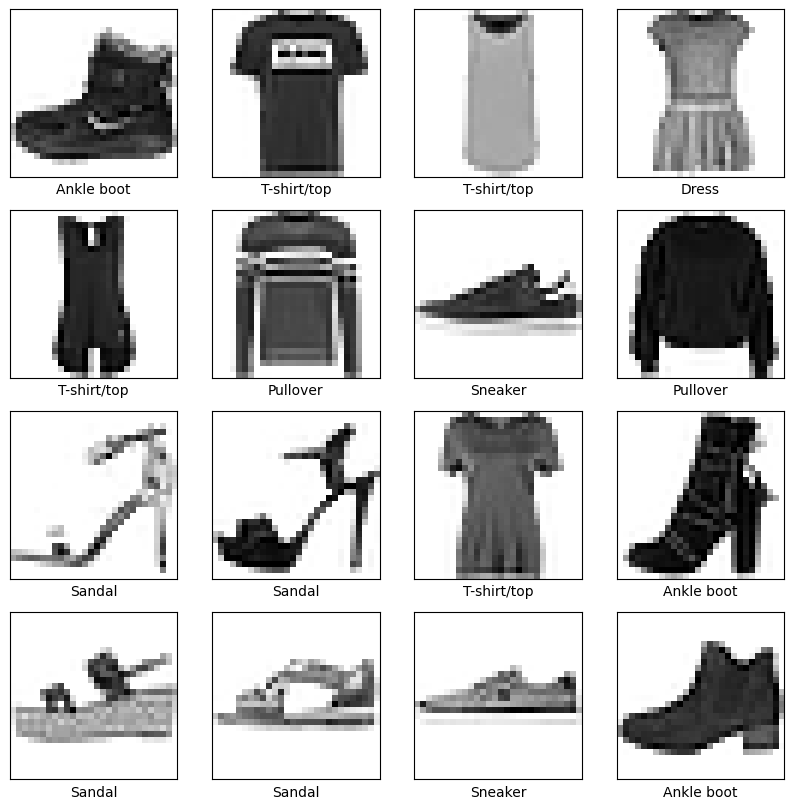

In [7]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])                         # remove x ticks
    plt.yticks([])                         # remove y ticks
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])    # add image label

We can make a zoom and plot any of these images with more detail:

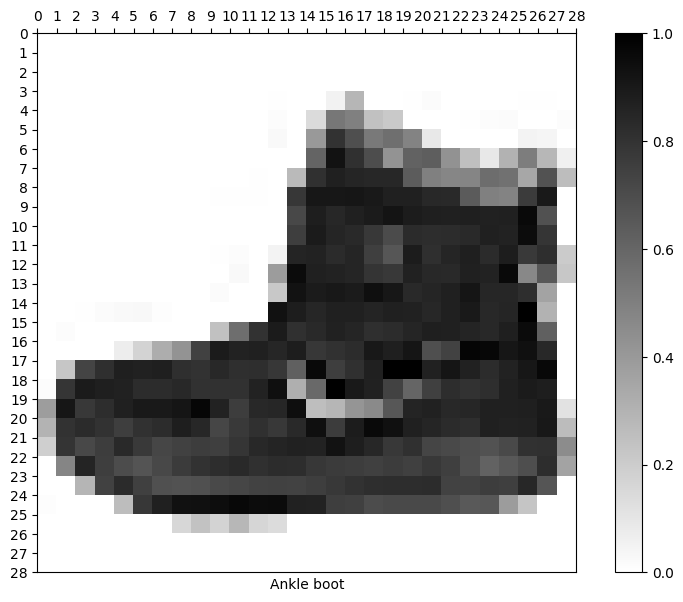

In [8]:
index = 0
_, ax = plt.subplots(figsize=(10,7))
plt.imshow(X_train[index], cmap=plt.cm.binary)
plt.xlabel(class_names[y_train[index]])
plt.colorbar()

ticks_pos = np.arange(-.5, 28, 1)
ticks_labs = np.arange(0, 29, 1)

ax.set_xticks(ticks_pos)
ax.set_yticks(ticks_pos)
ax.set_xticklabels(ticks_labs)
ax.set_yticklabels(ticks_labs)
ax.xaxis.tick_top()

To make clearer the relationship between images and arrays, we can overlap the numerical values of the matrix and its graphical representation:

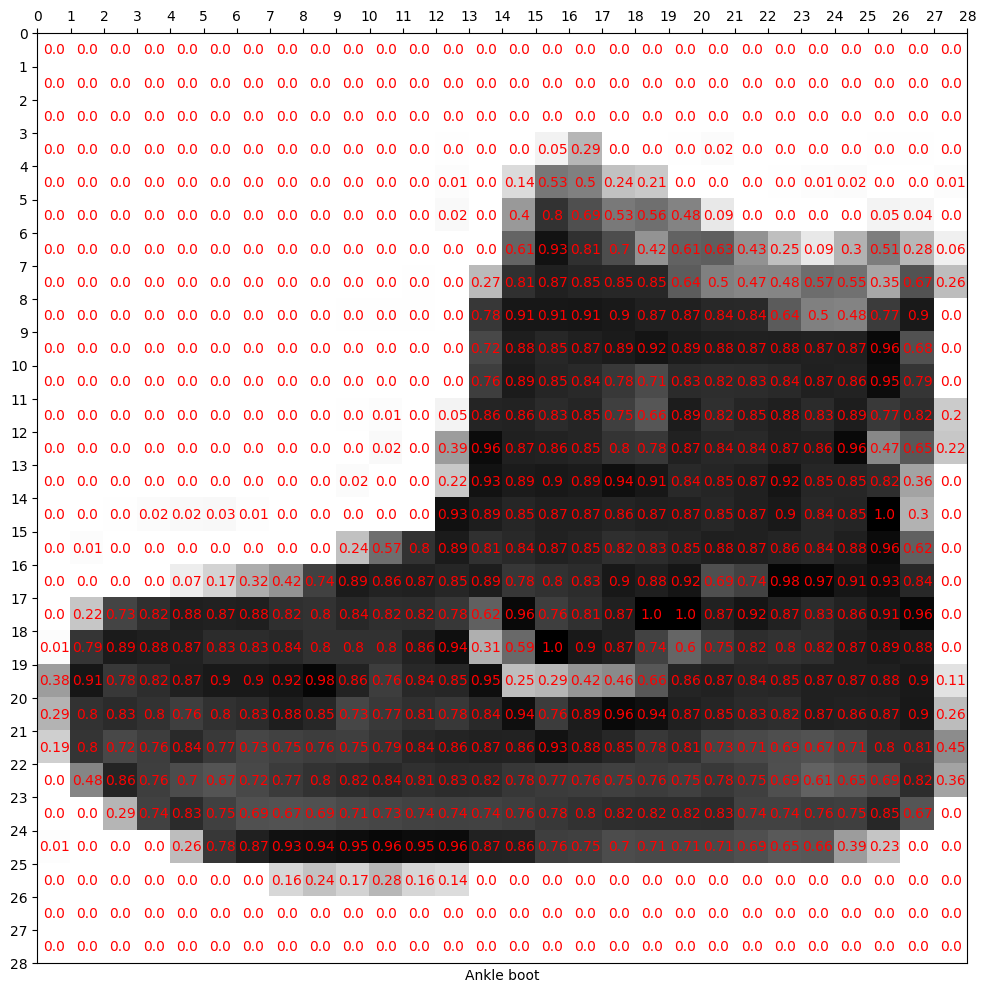

In [9]:
index = 0
_, ax = plt.subplots(figsize=(12,13))
plt.imshow(X_train[index], cmap=plt.cm.binary)
plt.xlabel(class_names[y_train[index]])

ticks_pos = np.arange(-.5, 28, 1)
ticks_labs = np.arange(0, 29, 1)

ax.set_xticks(ticks_pos)
ax.set_yticks(ticks_pos)
ax.set_xticklabels(ticks_labs)
ax.set_yticklabels(ticks_labs)
ax.xaxis.tick_top()

for i in range(28):
    for j in range(28):
        text = ax.text(j, i, round(X_train[index][i, j], 2), ha="center", va="center", color="red")

### 4. Model architecture

We will implement a simple CNN composed of one convolutional block followed by a standard MLP classifier. The architecture will be:
* Convolutional Block (Feature Extraction):
  > - `Conv2D` Layer: Scans for local patterns.  
  > - `MaxPooling2D` Layer: Downsamples the feature maps.  
* MLP Block (Decision Layer):
  > - `Dense` Layer: A standard fully connected layer.   
  > - `Output` Layer: A final dense layer for classification.  

Typically, real models concatenate multiple pairs of convolutional & pooling layers.

<br>
<br>

![picture](https://drive.google.com/uc?id=1vDe4gbSnzEMxFUqwIq5eXP9Mgh-sZaGn)




### 4.1. Input layer

Remember that NNs always have a first layer acting as a host or entry-point to the network. In CNNs this function is performed by the first Convolutional Layer. In some sense, it receives image input samples and provides them to the rest of the network "informing" the following layers about the input image shape.

In [10]:
input_layer = tf.keras.layers.InputLayer(shape=[28, 28, 1], name='input_layer')

### 4.2. Convolutional layer



This is the core building block of a CNN. It uses a set of learnable filters (kernels) to detect specific features like edges, curves, or textures. The key parameters are:
* __filters__: the number of kernels. Each kernel goal is to extract a feature from the image.
* __kernel_size__: it is the shape of the kernel. Typical shapes are: 3x3, 5x5 or 7x7.
* __strides__: it represents how many steps (pixels) the kernel is shifted along the image to perform the convolution. In fact, this parameter is a tuple (stride_h, stride_v) because we could consider different vertical and horizontal strides.
* __padding__: How to handle image borders. A decision must be taken about how to act when image borders are reached during the convolution operations.
> If padding = yes, the image borders are padded with zeros.  
> If padding = No, then no padding is added.  
* Finally, as any other layer, we need an __activation function__. Remember that s-shapes functions are avoided. They are substituted by functions of the ReLU family.

More details can be obtained in (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).



In [11]:
conv_1 = tf.keras.layers.Conv2D(filters=12,               # number of filters (number of kernels)
                                kernel_size=(3, 3),       # kernel shape
                                strides=(1, 1),           # how shift kernel moving along the image
                                padding='valid',          # either to include padding or not
                                activation='relu',        # activation function
                                name='conv_1',
                                input_shape=(28, 28, 1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Once our images are processed by this layer, their shape is altered:

* The number of channels of the transformed image = number of kernels. The "new image" has a channel built by each applied kernel (one channel for each extracted feature).

* The resulting dimensions depend on either padding is applied or not:
> * __Padding = yes__: dimensions are not altered.  
> * __Padding = no__: each dimension suffers a pixels reduction. This reduction amount is (kernel_size - 1).

In this concrete layer, we have selected padding = No, then the output shape is: (28-2, 28-2, 12) = (26,26,12).

<br>

![picture](https://drive.google.com/uc?id=1PNscVkRyvI6umnSMdXb7FZLmcoewEkwB)


### 4.3. Pooling layer

This layer job is to reduce the spatial dimensions (downsample) of each of the features (each of the channels) received from the previous layer. This makes the netowrk more computationally efficient and helps make the detected features more robust to small translations in the input image. We'll use Max Pooling, which takes the maximum vallue from each patch of the feature map.

It has two key parameters:
* __pool_size__: the image is divided into rectangles of this shape. After that, the maximum pixel value of the rectangle is selected.
* __strides__: typically this rectangle is shifted the same size of the pool. As a consequence, there is no overlapping between them. But if necessary, we could obtained overlapping rectangles.

In [12]:
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                      strides=(2, 2),
                                      name='pool_1')

After the pooling transformation, the resulting "image" can be easily calculated dividing the image shape by the pool_size.

In our case, the output shape will be: (26/2, 26/2, 12) = (13, 13, 12)

<br>

![picture](https://drive.google.com/uc?id=1NR_9TTD7XSnDAFOBLiXW2QWHr4tK18Iv)

### 4.4. MLP "Decision layer"

After feature extraction, we must take a decision about its class. For that, we pass the processed feature maps to standard MLP for the final classification. Always, this decision is taken by a group of dense layers. Hence, the final stage of the CNN is always a MLP (typically with multiple dense layers).

Remember that this stage only accepts 1D-arrays. Hence the 2D-arrays managed by the previous convolutional stage must be flattened.

Then, this MLP needs the following layers:

* A flatten layer. To make a transition between the preprocessing stage (2D-world) and the decision stage (1D-world).

* 1-2 dense layers. These layers facilitates the transformations between the huge flattened array and the 10-output classes.  

* An output layer. To take the final decision.

First of all, we define our flatten layer:

In [13]:
flatten_layer = tf.keras.layers.Flatten()

Once the flattened layer has completed its operation, the image has been transformed into a 1D-array of size: 13x13x12 = 2028.

After that, a dense layer is defined to reduce the dimensionality of the information from 2028 to 128.

In [14]:
dense_1 = tf.keras.layers.Dense(units=128, activation='relu', name='dense_1')

Finally, a 10-neuron layer is defined. As always,

* Output layer neurons = number of classes.
* Output layer activation function:
> * 2 classes: sigmoid  
> * (>2) classes: softmax

In [15]:
output_layer = tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer')

### 4.5. Stacking the Layers

All the previously created layers are stacked into a "list" of layers using the Sequential API.

In [16]:
model = tf.keras.Sequential([input_layer,
                            conv_1,         # output shape: (26,26,12)
                            pool_1,         # output shape: (13,13,12)
                            flatten_layer,  # output shape: 2028
                            dense_1,        # output shape: 128
                            output_layer    # output shape: 10
                          ])

#### 5. Parameters of the model



A description of the model can be obtained using `summary`. It shows the type, dimensionality and #params of each layer.

The input layer has no parameters, while the rest of layers have:

*   conv_2d: (3 x 3) x 12 + 12 = 120  (kernel_size_v x kernel_size_h x #channels) + kernels

*   max_pooling: No parameters.

*   flatten: No parameters

*   dense: 2028 x 128 = 259584 + 128 = 259712
*   output_layer = 128 x 10 + 10 = 1290

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 26, 26, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 13, 13, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       259,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,122 (1020.01 KB)

 Trainable params: 261,122 (1020.01 KB)

 Non-trainable params: 0 (0.00 B)

### 6. Functional API: alternative model definition

There are two main ways of defining a NN:
* A sequential API. Its the way we have used up to this point.
* A functional API. It is an alternative way of defining networks. It is much more flexible and is needed in some situations. Instead of creating a list of layers, layers are called as functions.

We can define our network using this functional API.

* First of all, we define an explicit Input layer indicating the shape of the input image.
* Surprisingly, the previously defined layers can be called as functions.
* Finally, instead of a `Sequential` list of layers, a `Model` is created. This model receives two arguments: inputs and outputs.  

In [18]:
inputs = tf.keras.Input(shape=(28, 28, 1), name='input_layer')
x = conv_1(inputs)
x = pool_1(x)
x = flatten_layer(x)
x = dense_1(x)
outputs = output_layer(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

It can be checked easily that both models: defined via Sequential and via Model are equivalent and have the same number of parameters.

In [19]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 26, 26, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 13, 13, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       259,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,122 (1020.01 KB)

 Trainable params: 261,122 (1020.01 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Model training

Before training, we need to compile the model to indicate:
* A loss function to be optimized.
* An optimization "technique".

In the previous MLP notebook we defined these parameters as strings.
```
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
```
In this ocassion, we will show an alternative way of defining them, via classes.


In [20]:
loss_function = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=loss_function,
    optimizer=optim,
    metrics=['accuracy'])

From the summary, we can notice that convolutional models expects that each input image is a tensor with the following structure:

(dim_1, dim_2, num_canales)

In our case, there is only one channel (grayscale). Then, its associated shape should be (28, 28, 1). But out dataset images are arrays with shape:  (28, 28).

In [21]:
X_train[0].shape

(28, 28)

Hence, we must add artifitially an extra dimension indicating that our grayscale images can be interpreted as 1 channel images.

In [22]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [23]:
X_train[0].shape

(28, 28, 1)

Now we can train the model with parameters:
* Between 7 and 10 epochs are enough to train.
* 20% is selected for validation.`

In [24]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    validation_split=0.2)

Epoch 1/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7877 - loss: 0.5975 - val_accuracy: 0.8777 - val_loss: 0.3463
Epoch 2/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8862 - loss: 0.3190 - val_accuracy: 0.8937 - val_loss: 0.2996
Epoch 3/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9028 - loss: 0.2686 - val_accuracy: 0.9000 - val_loss: 0.2822
Epoch 4/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9152 - loss: 0.2326 - val_accuracy: 0.9031 - val_loss: 0.2763
Epoch 5/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9253 - loss: 0.2038 - val_accuracy: 0.9034 - val_loss: 0.2758
Epoch 6/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9336 - loss: 0.1780 - val_accuracy: 0.9038 - val_loss: 0.2850
Epoch 7/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9424 - loss: 0.1552 - val_accuracy: 0.9039 - val_loss: 0.2969
Epoch 8/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9510 - loss: 0.1355 - val_accu

As always we plot the model's learning progress:

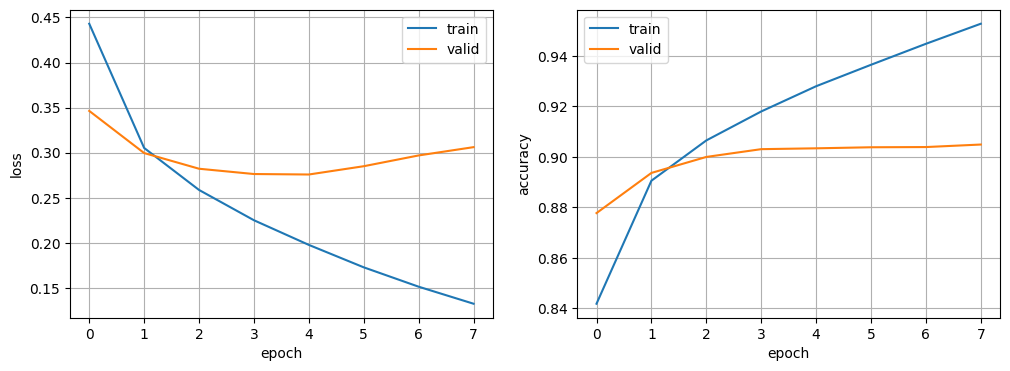

In [25]:
df_1 = pd.DataFrame({'loss_train': history.history['loss'],
                     'loss_valid': history.history['val_loss']
                    })

df_2 = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'accuracy_valid': history.history['val_accuracy']
                   })

data = [df_1, df_2]
y_labels = ['loss', 'accuracy']

f, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
for ax, y_label, df in zip(axs, y_labels, data):
    ax.plot(df, label=['train','valid'])
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(y_label)
    ax.legend();

In these plot we can observe an undesired behaviour that will be explained and tackled in the next session.

### 7. Model predictions

To obtain the model performance, comparing the prediction for $X\_test$ with $y\_test$ using `evaluate`:

In [26]:
res = model.evaluate(X_test,y_test, verbose=0)
print(f"model accuracy: {np.round(res[1],2)}")

model accuracy: 0.9


Given an input image, the model output can be obtained using the `predict` method. It corresponds to the output of the last layer that is interpreted as  the probability of the image to correspon to each of the ten classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


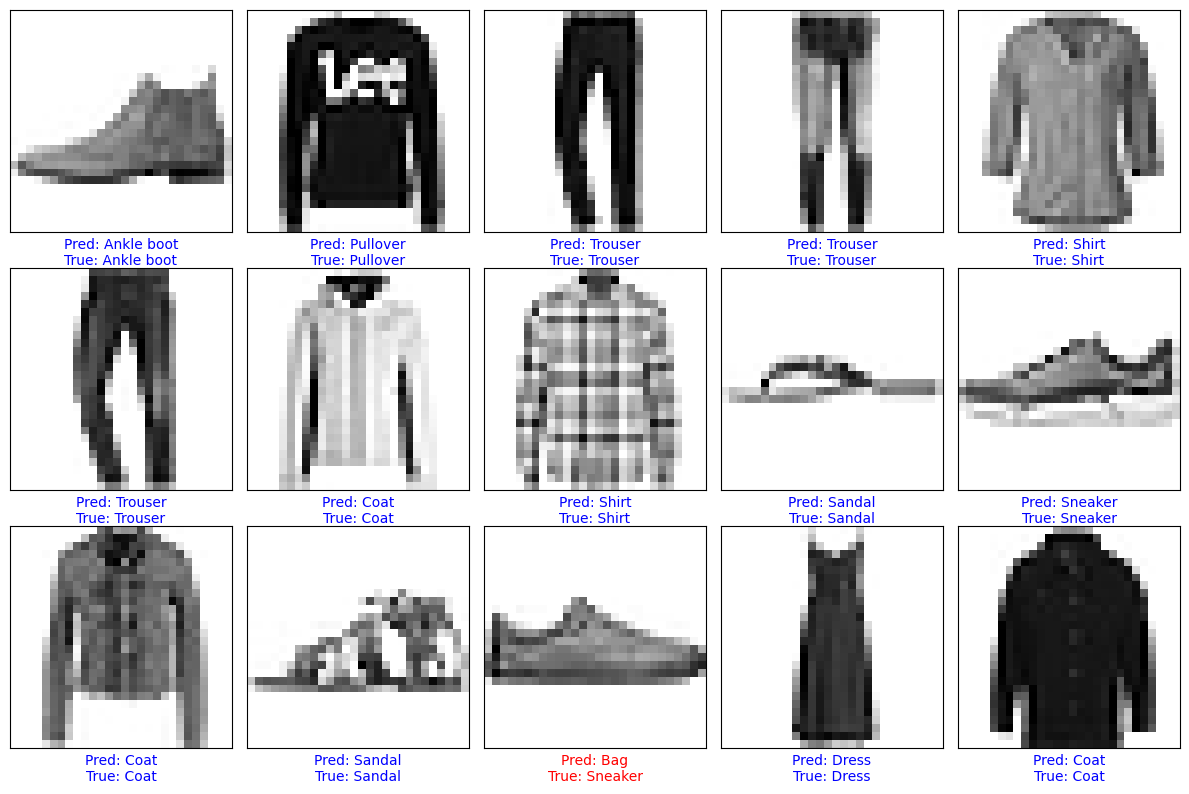

In [27]:
X_new = X_test[:15]
y_proba = model.predict(X_new)
y_pred = np.argmax(y_proba, axis=1)
y_true = y_test[:15]

plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_new[i], cmap=plt.cm.binary)

    predicted_label = class_names[y_pred[i]]
    true_label = class_names[y_true[i]]

    color = 'blue' if y_pred[i] == y_true[i] else 'red'

    plt.xlabel(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()

In [28]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

The predicted class associated to the image is obtained as the class with the higher probability:

In [29]:
y_predicted = np.argmax(y_proba.round(2), axis=1)
y_predicted

array([9, 2, 1])

In [30]:
y_test[:3]

array([9, 2, 1], dtype=uint8)

### 8. Conclusion

By using a simple convolutional architecture, we have significantly improved our results compared to the MLP from the previous session.

<br>

| Architecture| Image size  | # number of parameters  | Valid accuracy | Test accuracy |
|:-- |:-----: | :------------------: | :-----------------: | :-: |
| MLP|28 x 28 |     $≃$ 270K         |        88-89%          | 86% |
| Conv|28 x 28 |     $≃$ 260K         |        90-91%          | 91% |

<br>

Even with slightly fewer parameters, the CNN achieves a 5% increase in test accuracy. This demonstrates the power of using an architecture specifically designed for image data. The convolutional layers effectively extract relevant spatial features, allowing the model to learn efficiently and generalize better to new, unseen images.